In [170]:
!rm -rf /content/data
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/training/
   creating: data/training/square/
  inflating: data/training/square/2025-10-16_23-23-07.zip  
  inflating: data/training/square/2025-10-16_23-23-12.zip  
  inflating: data/training/square/2025-10-16_23-23-17.zip  
  inflating: data/training/square/2025-10-16_23-23-22.zip  
  inflating: data/training/square/2025-10-16_23-23-27.zip  
  inflating: data/training/square/2025-10-16_23-23-32.zip  
  inflating: data/training/square/2025-10-16_23-23-38.zip  
  inflating: data/training/square/2025-10-16_23-23-44.zip  
  inflating: data/training/square/2025-10-16_23-23-49.zip  
  inflating: data/training/square/2025-10-16_23-23-55.zip  
  inflating: data/training/square/2025-10-16_23-25-23.zip  
  inflating: data/training/square/2025-10-16_23-25-27.zip  
  inflating: data/training/square/2025-10-16_23-25-32.zip  
  inflating: data/training/square/2025-10-16_23-25-37.zip  
  inflating: data/training/square/2025-10-16_23-25

In [13]:
# Unzip /content/data/testing/*/*.zip into folders named after each zip (sans .zip)
# and remove the 4 unwanted CSV/metadata files from the extracted contents.

import glob, zipfile, shutil
from pathlib import Path

ZIP_PATTERN = "/content/data/training/*/*.zip"
UNWANTED = {
    "AccelerometerUncalibrated.csv",
    "GyroscopeUncalibrated.csv",
    "Metadata.csv",
    "Annotation.csv",
}

# LOCAL:
zip_fps = list(Path("../data/training").glob("*/*.zip"))
ROOT = Path("../data/training")
# CO-LAB:
# zip_fps = glob.glob(ZIP_PATTERN)
# ROOT   = "/content/data/training"

for zip_fp in zip_fps:
    zpath = Path(zip_fp)
    dest = zpath.with_suffix("")  # e.g., /.../session1.zip -> /.../session1
    if dest.exists():
        shutil.rmtree(dest)
    dest.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zpath, "r") as zf:
        zf.extractall(dest)

    # Remove unwanted files anywhere under the new folder
    for name in UNWANTED:
        for p in dest.rglob(name):
            try:
                p.unlink()
            except FileNotFoundError:
                pass

    print(f"Extracted {zpath.name} → {dest}")

# Clean up any accidental top-level copies in /content from previous unzips
for name in UNWANTED:
    top = Path("/content") / name
    if top.exists():
        top.unlink()


Extracted 2025-10-16_23-16-04.zip → ../data/training/triangle/2025-10-16_23-16-04
Extracted 2025-10-16_23-15-43.zip → ../data/training/triangle/2025-10-16_23-15-43
Extracted 2025-10-16_23-15-48.zip → ../data/training/triangle/2025-10-16_23-15-48
Extracted 2025-10-16_23-18-12.zip → ../data/training/triangle/2025-10-16_23-18-12
Extracted 2025-10-16_23-18-27.zip → ../data/training/triangle/2025-10-16_23-18-27
Extracted 2025-10-16_23-15-59.zip → ../data/training/triangle/2025-10-16_23-15-59
Extracted 2025-10-16_23-18-03.zip → ../data/training/triangle/2025-10-16_23-18-03
Extracted 2025-10-16_23-17-45.zip → ../data/training/triangle/2025-10-16_23-17-45
Extracted 2025-10-16_23-16-37.zip → ../data/training/triangle/2025-10-16_23-16-37
Extracted 2025-10-16_23-17-58.zip → ../data/training/triangle/2025-10-16_23-17-58
Extracted 2025-10-16_23-16-46.zip → ../data/training/triangle/2025-10-16_23-16-46
Extracted 2025-10-16_23-18-07.zip → ../data/training/triangle/2025-10-16_23-18-07
Extracted 2025-1

In [ ]:
# Simple & sane: Accelerometer + Orientation → world-frame linear accel → integrate to X–Z position
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.integrate import cumulative_trapezoid as cumtrapz

PLANE  = "xz"       # use world X–Z (you said +x left, +z up)
SCALE  = 0.35       # fit your plot limits
G      = 9.80665

def _read_xyz_time(fp, fs_fallback=100.0):
    df = pd.read_csv(fp)
    cols = {c.lower(): c for c in df.columns}
    if "seconds_elapsed" in cols:
        t = pd.to_numeric(df[cols["seconds_elapsed"]], errors="coerce").to_numpy(float)
    elif "time" in cols:
        t = pd.to_numeric(df[cols["time"]], errors="coerce").to_numpy(float)
    else:
        t = np.arange(len(df), dtype=float) / fs_fallback
    x = pd.to_numeric(df[cols["x"]], errors="coerce").to_numpy(float)
    y = pd.to_numeric(df[cols["y"]], errors="coerce").to_numpy(float)
    z = pd.to_numeric(df[cols["z"]], errors="coerce").to_numpy(float)
    return t, x, y, z

def _read_orientation(fp):
    """Return (t, qw, qx, qy, qz) from Orientation.csv which may have quaternion or yaw/pitch/roll."""
    df = pd.read_csv(fp)
    cols = {c.lower(): c for c in df.columns}
    # time
    if "seconds_elapsed" in cols:
        t = pd.to_numeric(df[cols["seconds_elapsed"]], errors="coerce").to_numpy(float)
    elif "time" in cols:
        t = pd.to_numeric(df[cols["time"]], errors="coerce").to_numpy(float)
    else:
        t = np.arange(len(df), dtype=float) / 100.0

    # quaternion present?
    if all(k in cols for k in ("qw","qx","qy","qz")):
        qw = pd.to_numeric(df[cols["qw"]], errors="coerce").to_numpy(float)
        qx = pd.to_numeric(df[cols["qx"]], errors="coerce").to_numpy(float)
        qy = pd.to_numeric(df[cols["qy"]], errors="coerce").to_numpy(float)
        qz = pd.to_numeric(df[cols["qz"]], errors="coerce").to_numpy(float)
    elif all(k in cols for k in ("w","x","y","z")):
        qw = pd.to_numeric(df[cols["w"]], errors="coerce").to_numpy(float)
        qx = pd.to_numeric(df[cols["x"]], errors="coerce").to_numpy(float)
        qy = pd.to_numeric(df[cols["y"]], errors="coerce").to_numpy(float)
        qz = pd.to_numeric(df[cols["z"]], errors="coerce").to_numpy(float)
    else:
        # yaw/pitch/roll (deg): expect columns like 'yaw','pitch','roll' or 'azimuth','pitch','roll'
        yaw  = pd.to_numeric(df[cols.get("yaw", cols.get("azimuth"))], errors="coerce").to_numpy(float)
        pitch= pd.to_numeric(df[cols["pitch"]], errors="coerce").to_numpy(float)
        roll = pd.to_numeric(df[cols["roll"]],  errors="coerce").to_numpy(float)
        # ZYX euler -> quaternion
        r, p, y = np.deg2rad(roll), np.deg2rad(pitch), np.deg2rad(yaw)
        cy, sy = np.cos(y*0.5), np.sin(y*0.5)
        cp, sp = np.cos(p*0.5), np.sin(p*0.5)
        cr, sr = np.cos(r*0.5), np.sin(r*0.5)
        qw = cr*cp*cy + sr*sp*sy
        qx = sr*cp*cy - cr*sp*sy
        qy = cr*sp*cy + sr*cp*sy
        qz = cr*cp*sy - sr*sp*cy
    return t, qw, qx, qy, qz

def _quat_to_rot(qw, qx, qy, qz):
    """Quaternion (w,x,y,z) → 3x3 rotation matrix. Maps device->world."""
    # normalize
    s = np.sqrt(qw*qw + qx*qx + qy*qy + qz*qz) + 1e-12
    w, x, y, z = qw/s, qx/s, qy/s, qz/s
    xx, yy, zz = x*x, y*y, z*z
    xy, xz, yz = x*y, x*z, y*z
    wx, wy, wz = w*x, w*y, w*z
    R = np.array([
        [1-2*(yy+zz),   2*(xy-wz),     2*(xz+wy)],
        [2*(xy+wz),     1-2*(xx+zz),   2*(yz-wx)],
        [2*(xz-wy),     2*(yz+wx),     1-2*(xx+yy)],
    ], dtype=float)
    return R

def _accori_to_world_pos(acc_fp, ori_fp, label, plane=PLANE, scale=SCALE):
    # read
    t_a, ax, ay, az = _read_xyz_time(acc_fp)
    t_o, qw, qx, qy, qz = _read_orientation(ori_fp)

    # heuristic: if accel magnitude median ~1, assume 'g' and convert to m/s^2
    mag = np.median(np.sqrt(ax*ax + ay*ay + az*az))
    if 0.6 < mag < 1.4:  # around 1 g
        ax, ay, az = ax*G, ay*G, az*G

    # interp quaternion to accel timestamps
    qw_i = np.interp(t_a, t_o, qw)
    qx_i = np.interp(t_a, t_o, qx)
    qy_i = np.interp(t_a, t_o, qy)
    qz_i = np.interp(t_a, t_o, qz)
    # renormalize
    qn = np.sqrt(qw_i*qw_i + qx_i*qx_i + qy_i*qy_i + qz_i*qz_i) + 1e-12
    qw_i, qx_i, qy_i, qz_i = qw_i/qn, qx_i/qn, qy_i/qn, qz_i/qn

    # rotate accel to world and subtract gravity
    N = len(t_a)
    awx = np.empty(N); awy = np.empty(N); awz = np.empty(N)
    for i in range(N):
        R = _quat_to_rot(qw_i[i], qx_i[i], qy_i[i], qz_i[i])  # device->world
        a_world = R @ np.array([ax[i], ay[i], az[i]])
        a_world[2] -= G
        awx[i], awy[i], awz[i] = a_world

    # integrate (trapezoid) with simple end-velocity correction
    vx = cumtrapz(awx, t_a, initial=0.0)
    vy = cumtrapz(awy, t_a, initial=0.0)
    vz = cumtrapz(awz, t_a, initial=0.0)
    ramp = np.linspace(0.0, 1.0, N)
    vx -= ramp * vx[-1]; vy -= ramp * vy[-1]; vz -= ramp * vz[-1]
    px = cumtrapz(vx, t_a, initial=0.0)
    py = cumtrapz(vy, t_a, initial=0.0)
    pz = cumtrapz(vz, t_a, initial=0.0)

    # choose plane, center & scale for your plot
    if plane == "xz": X, Y = px, pz
    elif plane == "xy": X, Y = px, py
    elif plane == "yz": X, Y = py, pz
    else: raise ValueError("plane must be 'xz','xy','yz'")
    X -= X.mean(); Y -= Y.mean()
    s = max(np.std(X), np.std(Y), 1e-9)
    X, Y = (X/s)*scale, (Y/s)*scale
    pts = [{"x": float(x), "y": float(y)} for x, y in zip(X, Y)]
    return {"strokePoints": pts, "label": label, "filename": str(acc_fp)}

# ---- Build strokes: use only Accelerometer.csv + Orientation.csv in each session ----
strokes = []
for label_dir in sorted(Path(ROOT).glob("*")):
    if not label_dir.is_dir(): continue
    for session_dir in sorted(label_dir.glob("*")):
        if not session_dir.is_dir(): continue
        acc = next((p for p in session_dir.glob("*.csv") if "accelerometer" in p.name.lower()), None)
        ori = next((p for p in session_dir.glob("*.csv") if "orientation"  in p.name.lower()), None)
        if acc and ori:
            strokes.append(_accori_to_world_pos(acc, ori, label_dir.name, plane=PLANE))

[{'strokePoints': [{'x': 0.29460757588161407, 'y': -0.18362688102359537}, {'x': 0.29459125425151894, 'y': -0.18363637333278918}, {'x': 0.29454429461649206, 'y': -0.18366286332182571}, {'x': 0.29447245976270997, 'y': -0.18370067478308372}, {'x': 0.29438498803189284, 'y': -0.1837413883906395}, {'x': 0.2942911969836478, 'y': -0.18377741798432734}, {'x': 0.2941978669885019, 'y': -0.18380726174870793}, {'x': 0.294111837618937, 'y': -0.18383427685845632}, {'x': 0.2940398677396523, 'y': -0.18386045528202855}, {'x': 0.2939859837846587, 'y': -0.1838814242042513}, {'x': 0.293949636668827, 'y': -0.18388882466267287}, {'x': 0.29392619340880566, 'y': -0.1838788796183802}, {'x': 0.2939104693913228, 'y': -0.18385542264328053}, {'x': 0.29389747543512806, 'y': -0.18382821251458403}, {'x': 0.29388274375632867, 'y': -0.18380953404762776}, {'x': 0.29386429326608143, 'y': -0.18380771502448373}, {'x': 0.29384136203720823, 'y': -0.1838246675819392}, {'x': 0.2938152045967737, 'y': -0.18385942982391584}, {'x':

In [18]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.plot(x_array, y_array)

  plt.show()

In [19]:
# Flip vertically: make bottom become top (y -> -y)

def flip_stroke_vertical(stroke):
    stroke["strokePoints"] = [{"x": float(p["x"]), "y": -float(p["y"])} for p in stroke["strokePoints"]]
    return stroke

for s in strokes:
    for p in s["strokePoints"]:
        p["y"] = -float(p["y"])



In [20]:
import random

def _label(s):
    return str(s.get("label","")).strip().lower()

def sample_by_label(strokes, label, k, shuffle=True, seed=None):
    seed = random.randint(0, 1000000) if seed is None else seed
    items = [s for s in strokes if _label(s) == label]
    if shuffle:
        rnd = random.Random(seed)
        rnd.shuffle(items)
    return items[:k]

def plot_tests(strokes, n_square=5, n_triangle=5, shuffle=True, seed=None):
    seed = random.randint(0, 1000000) if seed is None else seed
    squares   = sample_by_label(strokes, "square",   n_square,   shuffle, seed)
    triangles = sample_by_label(strokes, "triangle", n_triangle, shuffle, seed+1)
    for s in squares + triangles:
        plot_stroke(s)



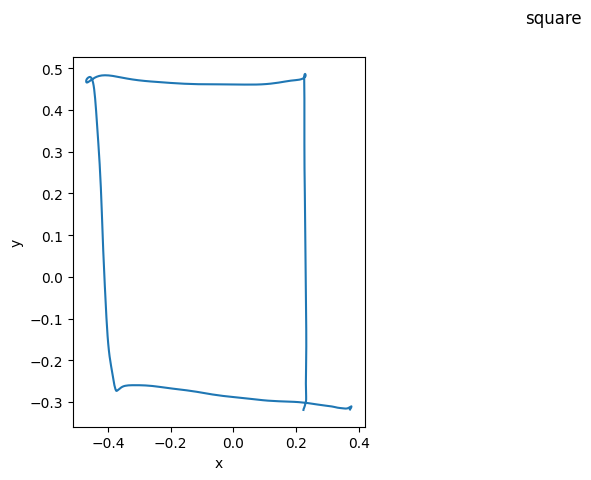

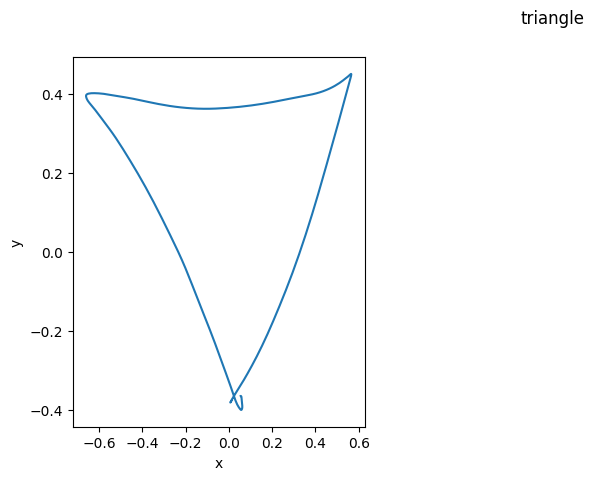

In [21]:
plot_tests(strokes, n_square=1, n_triangle=1, shuffle=True)

In [22]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

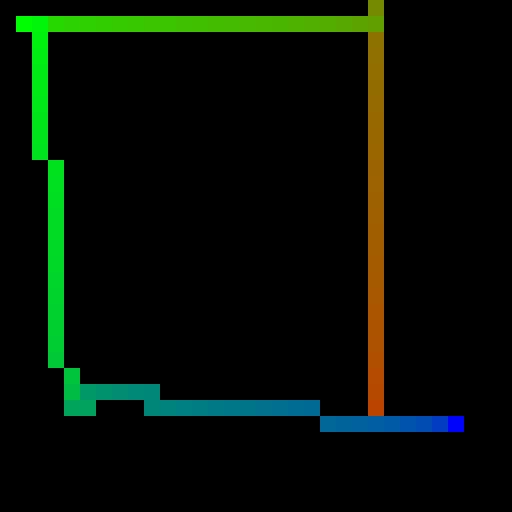

In [23]:
raster = rasterize_stroke(strokes[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [24]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [157]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes.copy()
np.random.shuffle(shuffled_strokes)

test_percentage = 20
validation_percentage = 20
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

AUTO_REMOVE = True

if AUTO_REMOVE:
    rm_paths = [Path("./test").resolve(), Path("./train").resolve(), Path("./validation").resolve(),]
    print()
    for rm_path in rm_paths:
        if rm_path.exists():
            shutil.rmtree(rm_path)
            print(f"Folder '{rm_path}' deleted successfully.")

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)


Folder '/mnt/raid0/matt/Documents/Education/Graduate/EmbeddedAI/lab-3-building-a-dataset-team6/model/test' deleted successfully.
Folder '/mnt/raid0/matt/Documents/Education/Graduate/EmbeddedAI/lab-3-building-a-dataset-team6/model/train' deleted successfully.
Folder '/mnt/raid0/matt/Documents/Education/Graduate/EmbeddedAI/lab-3-building-a-dataset-team6/model/validation' deleted successfully.


In [177]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
CLASS_NAMES = ["square", "triangle"]
validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
validation_ds_prefetch = validation_ds.prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
train_ds_prefetch = train_ds.prefetch(buffer_size=32)

test_ds = image_dataset_from_directory(
    directory='test',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
test_ds_prefetch = test_ds.prefetch(buffer_size=32)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 88 files belonging to 2 classes.
Found 264 files belonging to 2 classes.
Found 88 files belonging to 2 classes.

label names: ['square' 'triangle']


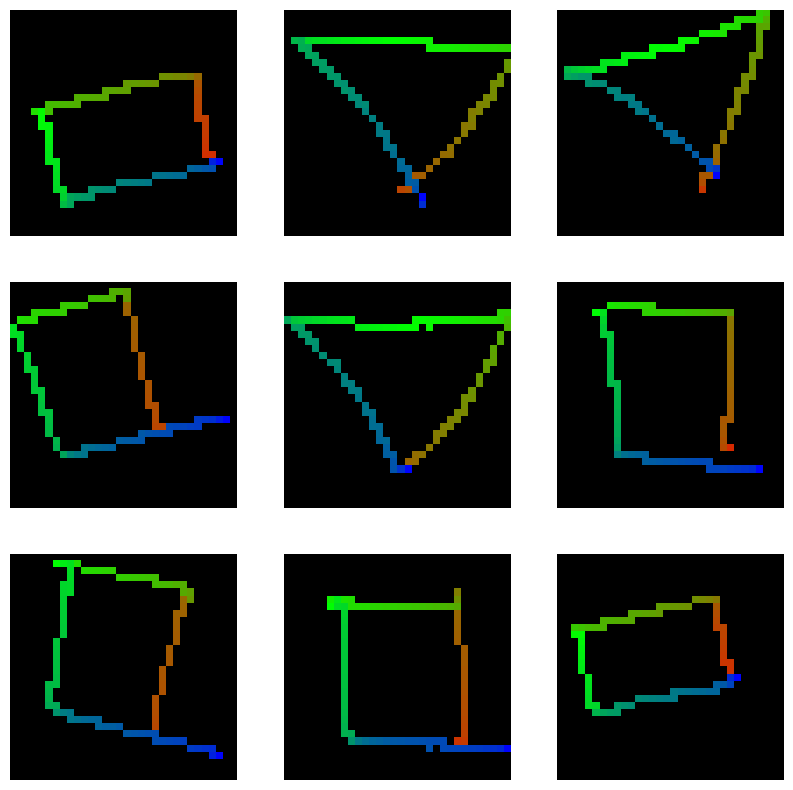

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [175]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [161]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=len(CLASS_NAMES))
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [182]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds_prefetch, epochs=epochs, validation_data=validation_ds_prefetch,
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 9.9608e-05
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1652e-04 - val_accuracy: 1.0000 - val_loss: 9.7313e-05
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 7.5885e-04 - val_accuracy: 1.0000 - val_loss: 9.1420e-05
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.4535e-04 - val_accuracy: 1.0000 - val_loss: 7.9016e-05
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 1.0675e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.6034e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.8357e-04
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 6.9189e-04 - val

Text(0, 0.5, 'Accuracy [%]')

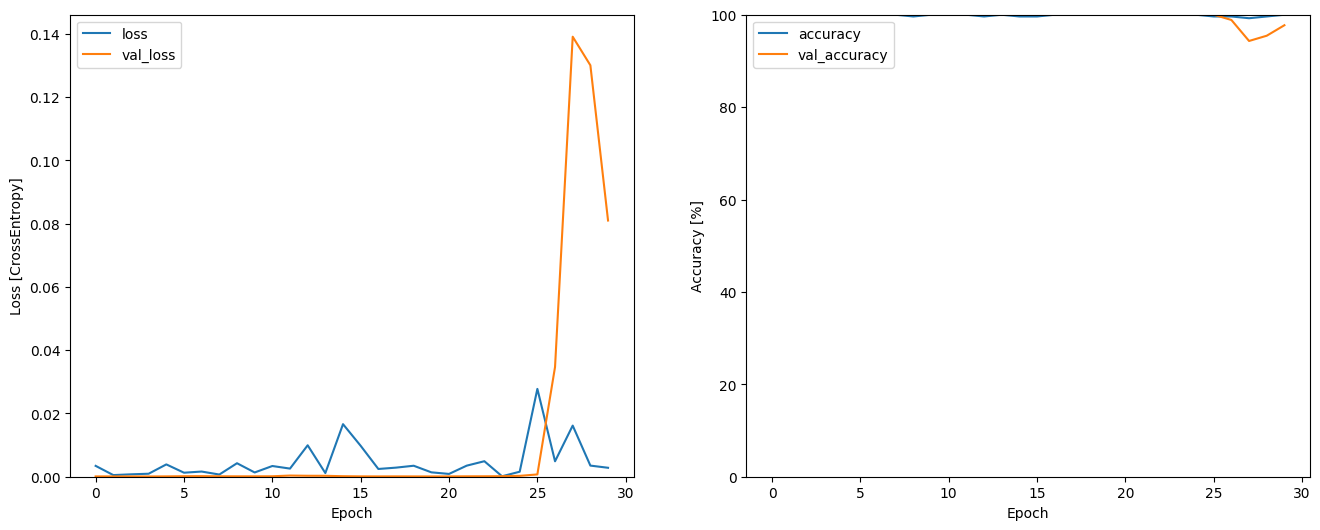

In [183]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
plt.ylabel("Loss [CrossEntropy]")

plt.subplot(1, 2, 2)
plt.plot(
    history.epoch,
    100 * np.array(metrics["accuracy"]),
    100 * np.array(metrics["val_accuracy"]),
)
plt.legend(["accuracy", "val_accuracy"])
plt.ylim([0, 100])
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

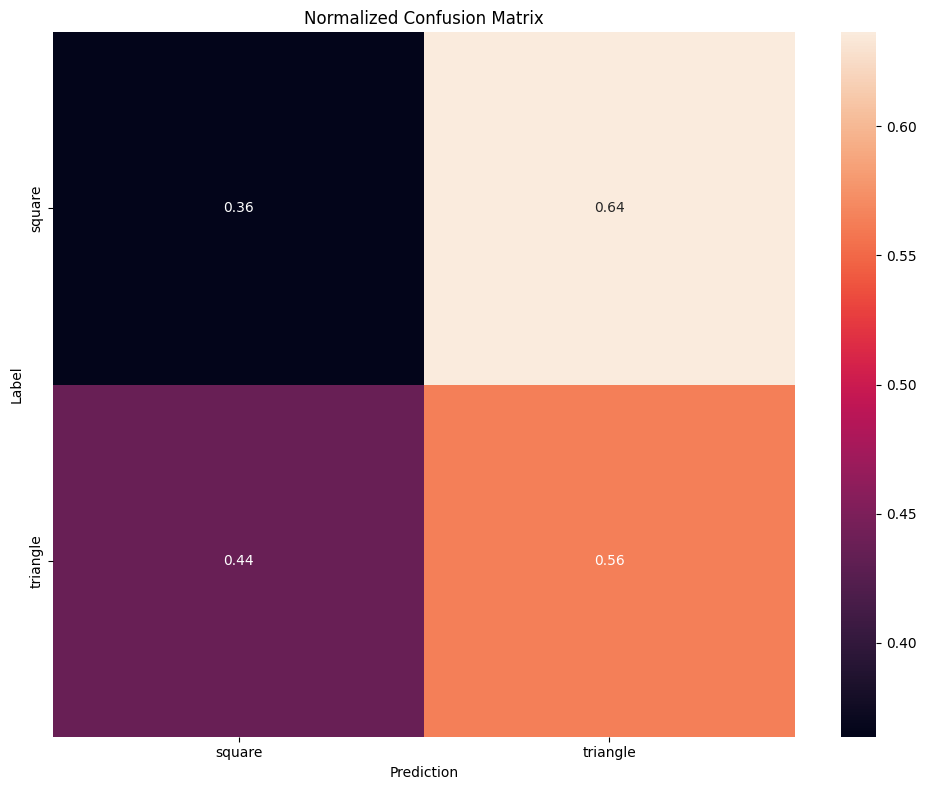

In [185]:
import seaborn as sns

eval_ds = test_ds

y_true = tf.concat([y for _, y in eval_ds], axis=0)

y_pred = tf.argmax(model.predict(eval_ds, verbose=0), axis=1)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(CLASS_NAMES), dtype=tf.float32)
cm = cm / tf.reduce_sum(cm, axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm.numpy(), xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, annot=True, fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.tight_layout()
plt.show()
